In [0]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from glob import glob
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm_notebook

In [0]:
import torch
import torch.nn as nn
import torch.optim as optim

import numpy as np

import random
import math
import time

# Load data

In [0]:
names = ['id', 'cycle', 'setting1', 'setting2', 'setting3', 's1', 's2', 's3',
         's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14',
         's15', 's16', 's17', 's18', 's19', 's20', 's21']
df = pd.read_csv('https://raw.githubusercontent.com/umbertogriffo/Predictive-Maintenance-using-LSTM/master/Dataset/PM_train.txt', 
                 header=None, usecols=range(26), names=names, sep=' ')
df.sort_values(['id', 'cycle'], inplace=True)
df.head()

id  cycle  setting1  setting2  setting3  ...  s17   s18    s19    s20      s21
0   1      1   -0.0007   -0.0004     100.0  ...  392  2388  100.0  39.06  23.4190
1   1      2    0.0019   -0.0003     100.0  ...  392  2388  100.0  39.00  23.4236
2   1      3   -0.0043    0.0003     100.0  ...  390  2388  100.0  38.95  23.3442
3   1      4    0.0007    0.0000     100.0  ...  392  2388  100.0  38.88  23.3739
4   1      5   -0.0019   -0.0002     100.0  ...  393  2388  100.0  38.90  23.4044

[5 rows x 26 columns]

In [0]:
def exp_hi(t, size):
    if int(size * 0.05) > t:
        return 1
    elif t > int(size * 0.95):
      return 0
    else:
      return 1 - np.exp(np.log(0.05)*(size-t)/((1-0.05)*(size)))

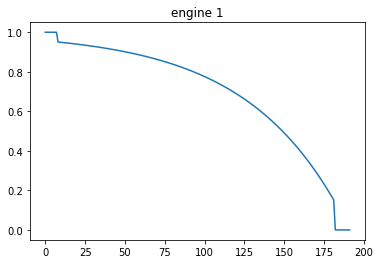

In [0]:
df.query('id == 1').cycle.apply(exp_hi, args=(df.query('id == 1').shape[0],)).plot(title='engine 1');

In [0]:
def preprocess_data(df, n_components=3):
    scaler = StandardScaler()
    pca = PCA(n_components)
    columns = list(df.columns[:2]) + [f'x_{i}' for i in range(1, 1+n_components)]
    new_df = pd.DataFrame(
        np.concatenate((df.iloc[:, :2], pca.fit_transform(df.iloc[:, 2:])), axis=1),
        columns=columns
    )
    new_df.iloc[:, 2:] = scaler.fit_transform(new_df.iloc[:, 2:])
    new_df[['id', 'cycle']] = new_df[['id', 'cycle']].astype(int)
    return new_df

In [0]:
X_train = preprocess_data(df)
X_train.head()

id  cycle       x_1       x_2       x_3
0   1      1 -0.637278 -0.733590  0.976637
1   1      2 -0.837801 -0.270058  1.123832
2   1      3 -0.575825 -0.389907  0.077717
3   1      4 -0.670467 -0.842558 -0.751308
4   1      5 -0.509579 -0.429609 -1.315091

In [0]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [0]:
def window(df, window_size=10, num_cycles=20):
    for unit in sorted(df['id'].unique()):
        unit_df = df.query(f'id == {unit}')
        # for i in range(unit_df.shape[0] - window_size + 1):
        for i in range(min(unit_df.shape[0] - window_size + 1, num_cycles)):
            yield torch.tensor(unit_df.iloc[i:i+window_size, 2:].to_numpy()[:,None], 
                               dtype=torch.float32, device=device)

In [0]:
counter = 0
for each in window(X_train):
    counter += 1
    if counter == 1:
        break
each.shape

torch.Size([10, 1, 3])

# Model

In [0]:
class Encoder(nn.Module):
    def __init__(self, input_dim, hid_dim, n_layers, dropout):
        super().__init__()
        
        self.hid_dim = hid_dim
        self.n_layers = n_layers
        
        self.rnn = nn.LSTM(input_dim, hid_dim, n_layers, dropout=dropout)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, input):
        
        #input = [seq len, batch size, input dim]
        
        embedded = self.dropout(input)
        
        #embedded = [seq len, batch size, input dim]
        
        outputs, (hidden, cell) = self.rnn(embedded)
        
        #outputs = [seq len, batch size, hid dim]
        #hidden = [n layers, batch size, hid dim]
        #cell = [n layers, batch size, hid dim]
        
        #outputs are always from the top hidden layer
        
        return hidden, cell

In [0]:
class Decoder(nn.Module):
    def __init__(self, output_dim, hid_dim, n_layers, dropout):
        super().__init__()
        
        self.output_dim = output_dim
        self.hid_dim = hid_dim
        self.n_layers = n_layers
        
        self.rnn = nn.LSTM(output_dim, hid_dim, n_layers, dropout=dropout)
        
        self.fc_out = nn.Linear(n_layers*hid_dim, output_dim)
        # self.fc_out = nn.Linear(hid_dim, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, input, hidden, cell):
        
        #input = [batch size, hid dim]
        #hidden = [n layers, batch size, hid dim]
        #cell = [n layers, batch size, hid dim]
        
        input = input.unsqueeze(0)
        
        #input = [1, batch size, input dim]
        
        embedded = self.dropout(input)
        
        #embedded = [1, batch size, input dim]
                
        output, (hidden, cell) = self.rnn(embedded, (hidden, cell))
        
        #seq len and n directions will always be 1 in the decoder, therefore:
        #output = [1, batch size, hid dim]
        #hidden = [n layers, batch size, hid dim]
        #cell = [n layers, batch size, hid dim]
        
        # prediction = self.fc_out(output.transpose(0, 1).view(-1, hid_dim))
        prediction = self.fc_out(hidden.transpose(0, 1).view(-1, self.n_layers*self.hid_dim))
        # prediction = self.fc_out(hidden.squeeze(1).view(-1, n_layers*hid_dim))
        
        #prediction = [batch size, output dim]
        
        return prediction, hidden, cell

In [0]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        self.device = device
        
        assert encoder.hid_dim == decoder.hid_dim, \
            "Hidden dimensions of encoder and decoder must be equal!"
        assert encoder.n_layers == decoder.n_layers, \
            "Encoder and decoder must have equal number of layers!"
        
    def forward(self, src, trg, teacher_forcing_ratio=1):
        
        #src = [seq len, batch size, num features]
        
        batch_size = src.shape[1]
        seq_len = src.shape[0]
        num_features = self.decoder.output_dim
        
        #tensor to store decoder outputs
        outputs = torch.zeros(seq_len, batch_size, num_features).to(self.device)
        
        #last hidden state of the encoder is used as the initial hidden state of the decoder
        hidden, cell = self.encoder(src)
        
        #first input to the decoder is the <sos> tokens
        # input = trg[-1,:]
        input = torch.zeros(batch_size, num_features, device=device)
        
        # for t in range(0, seq_len):
        for t in range(seq_len-1, -1, -1):
            
            #insert input token embedding, previous hidden and previous cell states
            #receive output tensor (predictions) and new hidden and cell states
            output, hidden, cell = self.decoder(input, hidden, cell)
            
            #place predictions in a tensor holding predictions for each token
            outputs[t] = output.squeeze(0)
            
            #get the highest predicted token from our predictions
            # top1 = output.argmax(1) 
            
            #if teacher forcing, use actual next token as next input
            #if not, use predicted token
            input = trg[t] if teacher_forcing_ratio else output
        
        return outputs

# Training model

In [0]:
BATCH_SIZE = 20
INPUT_DIM = X_train.iloc[:, 2:].shape[1]
OUTPUT_DIM = X_train.iloc[:, 2:].shape[1]
HID_DIM = 30
N_LAYERS = 5
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5

enc = Encoder(INPUT_DIM, HID_DIM, N_LAYERS, ENC_DROPOUT)
dec = Decoder(OUTPUT_DIM, HID_DIM, N_LAYERS, DEC_DROPOUT)

model = Seq2Seq(enc, dec, device).to(device)

In [0]:
def init_weights(m):
    for name, param in m.named_parameters():
        nn.init.uniform_(param.data, -0.08, 0.08)
        
model.apply(init_weights)

Seq2Seq(
  (encoder): Encoder(
    (rnn): LSTM(3, 20, num_layers=2, dropout=0.5)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): Decoder(
    (rnn): LSTM(3, 20, num_layers=2, dropout=0.5)
    (fc_out): Linear(in_features=40, out_features=3, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)

In [0]:
optimizer = optim.Adam(model.parameters())
criterion = nn.MSELoss()

In [0]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [0]:
def train(model, iterator, optimizer, criterion):
    
    model.train()
    
    epoch_loss = 0
    batch_size = 0
    
    for i, batch in enumerate(iterator):
        
        src = batch
        trg = batch
        batch_size += batch.shape[1]
        
        optimizer.zero_grad()
        
        output = model(src, trg)
        
        #trg = [trg len, batch size, output dim]
        #output = [trg len, batch size, output dim]
        
        output_dim = output.shape[-1]
        
        output = output.view(-1, output_dim)
        trg = trg.view(-1, output_dim)
        
        # trg = [trg len * batch size, output_dim]
        #output = [trg len * batch size, output dim]
        
        loss = criterion(output, trg)
        
        loss.backward()
        
        # torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        
        epoch_loss += loss.item()
        
    return epoch_loss / batch_size

In [0]:
N_EPOCHS = 10
loss_history = []

for epoch in range(N_EPOCHS):
    
    start_time = time.time()

    train_iterator = window(X_train, BATCH_SIZE)

    train_loss = train(model, train_iterator, optimizer, criterion)
    loss_history.append(train_loss)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f}')

Epoch: 01 | Time: 1m 34s
	Train Loss: 0.443
Epoch: 02 | Time: 1m 35s
	Train Loss: 0.418
Epoch: 03 | Time: 1m 36s
	Train Loss: 0.405
Epoch: 04 | Time: 1m 35s
	Train Loss: 0.388
Epoch: 05 | Time: 1m 35s
	Train Loss: 0.377
Epoch: 06 | Time: 1m 36s
	Train Loss: 0.366
Epoch: 07 | Time: 1m 36s
	Train Loss: 0.361
Epoch: 08 | Time: 1m 35s
	Train Loss: 0.355
Epoch: 09 | Time: 1m 36s
	Train Loss: 0.349
Epoch: 10 | Time: 1m 36s
	Train Loss: 0.344


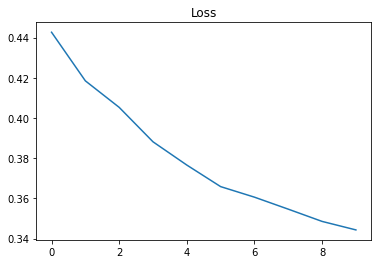

In [0]:
plt.title("Loss")
plt.plot(loss_history)
plt.show()

In [0]:
def save_model(model, loss, optimizer, epoch, loss_history, name='model'):
    out_path = f'./{name}/logs/'
    if not os.path.exists(out_path):
        os.makedirs(out_path, exist_ok=True)
    data_frame = pd.DataFrame(data={'loss': loss_history})
    data_frame.to_csv(out_path + 'log.csv')
    
    out_path = f'./{name}/checkpoints'
    if not os.path.exists(out_path):
        os.makedirs(out_path, exist_ok=True)   
    PATH = '{}/checkpoint.pth.tar'.format(out_path)
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss,
    }, PATH)

In [0]:
def copy_to_gdrive(name):
    path = f'/content/drive/My Drive/master_diploma/{name}'
    if os.path.exists(path):
        shutil.rmtree(path)
    # os.makedirs(path, exist_ok=True)
    shutil.copytree(f'./{name}', path)

In [ ]:
import os
import shutil
from google.colab import drive
drive.mount('/content/drive')

In [0]:
name = 'model_p3_c30_n5_w20_e10'
save_model(model, criterion, optimizer, N_EPOCHS, loss_history, name)
copy_to_gdrive(name)

# HI and RUL

In [0]:
def engine_window(df, window_size=10):
    for unit in sorted(df['id'].unique()):
        counter = -1
        unit_df = df.query(f'id == {unit}')
        for i in range(np.max([unit_df.shape[0] - window_size + 1, 1])):
            counter += 1
            yield unit_df.shape[0], counter, \
                  torch.tensor(unit_df.iloc[i:i+window_size, 2:].to_numpy()[:, None], 
                               dtype=torch.float32, device=device)

In [0]:
def predict(model, iterator, batch_size=BATCH_SIZE):
    
    model.eval()
       
    units = []
    counts = None
    sums = None

    for unit_size, window_num, batch in iterator:

        if window_num == 0:
            counts = np.zeros(unit_size)
            sums = np.zeros((unit_size, batch.shape[-1]))

        src = batch
        trg = batch
        
        output = model(src, trg, 0)
        output_shape = output.shape[0]

        counts[window_num:window_num+output_shape] += np.ones(output_shape)
        sums[window_num:window_num+output_shape, :] += output.data.cpu().numpy()[:, 0, :]
        if window_num == unit_size - batch_size or unit_size < batch_size:
            units.append(sums / counts[:, None])

    return units

In [0]:
train_iterator = engine_window(X_train, BATCH_SIZE)
units = predict(model, train_iterator)

In [0]:
def get_hi_curves(df, units):
    # assert df.iloc[:, 2].shape == units[0].shape

    curves = []
    for i, unit_id in enumerate(df['id'].unique()):
        errors = np.linalg.norm(df.query(f'id == {unit_id}').iloc[:, 2:] - units[i], 2, axis=1)
        normalized_errors = (errors.max() - errors) / (errors.max() - errors.min())
        curves.append(normalized_errors)
    return curves

In [0]:
len(units)

100

In [0]:
hi_curves = get_hi_curves(X_train, units)

In [0]:
def plot_exp_hi(num_cycles):
    return [exp_hi(t, num_cycles) for t in range(num_cycles)]

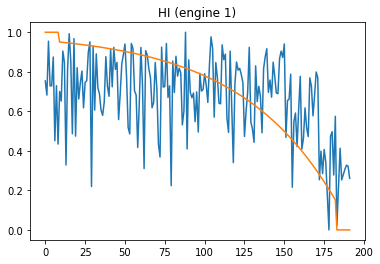

In [0]:
plt.title("HI (engine 1)")
plt.plot(hi_curves[0])
plt.plot(plot_exp_hi(len(hi_curves[0])))
plt.show()

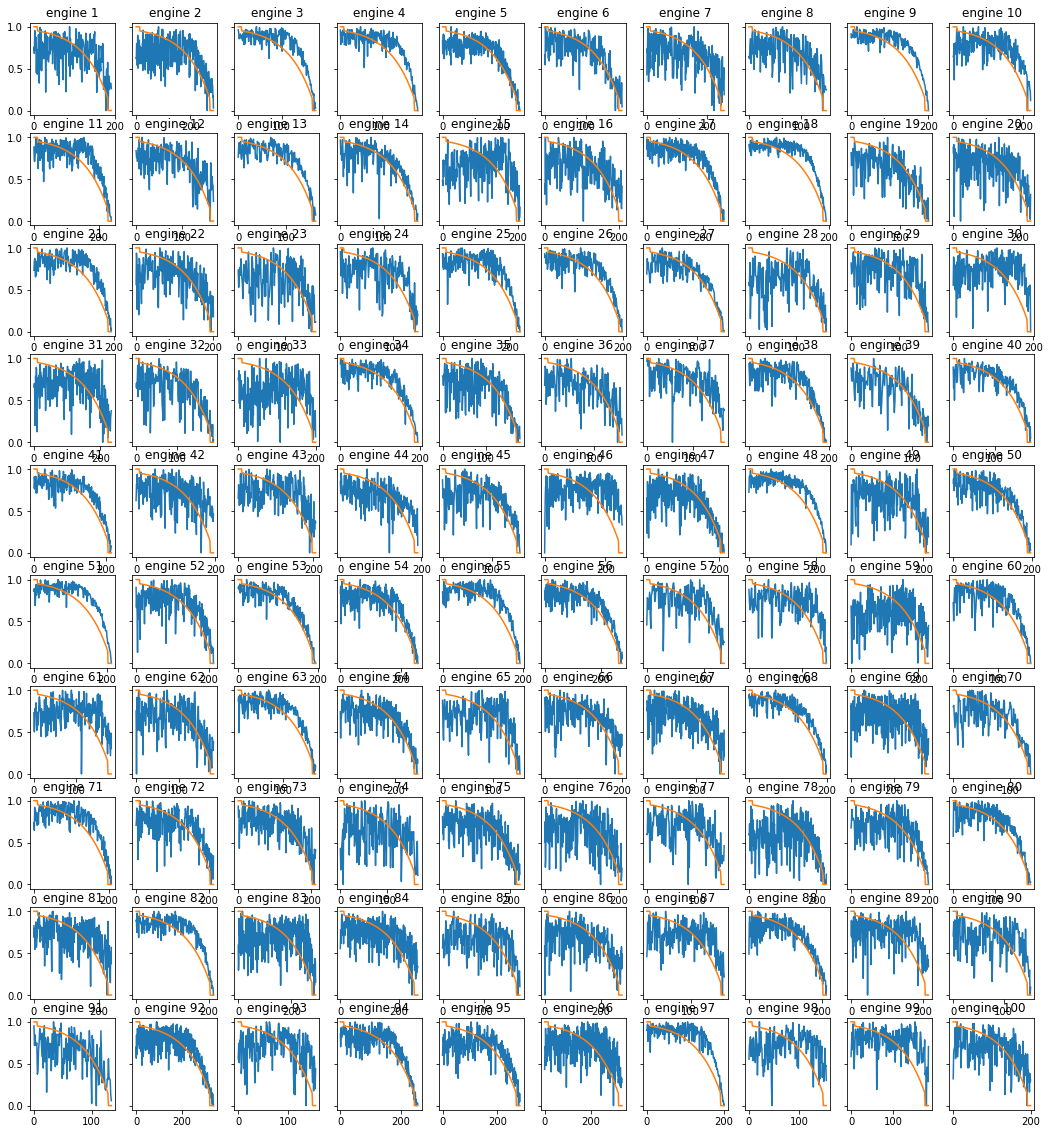

In [0]:
fig, axes = plt.subplots(10, 10, sharey=True, figsize=(18, 20))
for i, curve in enumerate(hi_curves):
    axes[i // 10, i % 10].plot(curve)
    axes[i // 10, i % 10].plot(plot_exp_hi(len(curve)))
    axes[i // 10, i % 10].set_title(f'engine {i+1}')
fig.tight_layout()

# Calculating RUL on test_set

In [0]:
rul_true = pd.read_csv('https://raw.githubusercontent.com/umbertogriffo/Predictive-Maintenance-using-LSTM/master/Dataset/PM_truth.txt', 
                       header=None, usecols=range(1), sep=' ', names=['RUL'])

In [0]:
test_df = pd.read_csv('https://raw.githubusercontent.com/umbertogriffo/Predictive-Maintenance-using-LSTM/master/Dataset/PM_test.txt', 
                      header=None, usecols=range(26), names=names, sep=' ')
test_df.head()

id  cycle  setting1  setting2  setting3  ...  s17   s18    s19    s20      s21
0   1      1    0.0023    0.0003     100.0  ...  392  2388  100.0  38.86  23.3735
1   1      2   -0.0027   -0.0003     100.0  ...  393  2388  100.0  39.02  23.3916
2   1      3    0.0003    0.0001     100.0  ...  393  2388  100.0  39.08  23.4166
3   1      4    0.0042    0.0000     100.0  ...  391  2388  100.0  39.00  23.3737
4   1      5    0.0014    0.0000     100.0  ...  390  2388  100.0  38.99  23.4130

[5 rows x 26 columns]

In [0]:
X_test = preprocess_data(test_df)

In [0]:
test_iterator = engine_window(X_test, BATCH_SIZE)
test_units = predict(model, test_iterator)

In [0]:
len(test_units), X_test.id.nunique()

(100, 100)

In [0]:
test_curves = get_hi_curves(X_test, test_units)

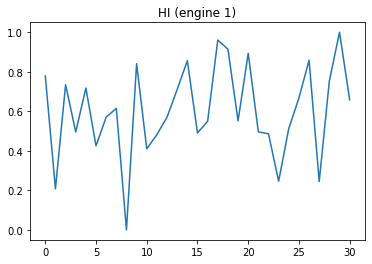

In [0]:
plt.title("HI (engine 1)")
plt.plot(test_curves[0])
plt.show()

In [0]:
def count_rul(hi_curves, test_curve, tau, Lambda, alpha, R_max):
    s = np.array([])
    r_hat = np.array([])
    for hi_curve in hi_curves:
        L = len(test_curve)
        cur_tau = min(tau, len(hi_curve)-L)
        for t in range(cur_tau):
            d2 = np.square(test_curve[:L] - hi_curve[t:t+L]).mean()
            s = np.append(s, np.exp(-d2 / Lambda))
            r_hat = np.append(r_hat, len(hi_curve) - L - t)
    s_max = s.max()
    mask = (s >= alpha * s_max)
    rul = np.min([np.round(np.average(r_hat[mask], weights=s[mask])), R_max])
    return rul

In [0]:
def count_S(delta, tau1=13, tau2=10):
    gamma = np.where(delta < 0, 1/tau1, 1/tau2)
    return np.sum(np.exp(np.multiply(gamma, np.abs(delta))) - 1)

In [0]:
def count_A(delta, tau1=13, tau2=10):
    ind = np.where((delta >= -tau1) & (delta <= tau2), 1, 0)
    return 100 * ind.mean()

In [0]:
def count_MAE(delta):
    return np.abs(delta).mean()

In [0]:
def count_MSE(delta):
    return np.square(delta).mean()

In [0]:
def count_MAPE1(delta, rul_true):
    return 100 * np.mean(np.abs(delta) / rul_true)

In [0]:
def count_MAPE2(delta, cycles_num, rul_true):
    return 100 * np.mean(np.abs(delta) / (cycles_num + rul_true))

In [0]:
predicted_ruls = []
for test_curve in test_curves:
    rul = count_rul(hi_curves, test_curve, 40, 0.1, 0.8, 125)
    predicted_ruls.append(rul)
delta = np.array(predicted_ruls) - rul_true.RUL.values

In [0]:
data = [
    count_S(delta),
    count_A(delta),
    count_MAE(delta),
    count_MSE(delta),
    count_MAPE1(delta, rul_true.RUL.values),
    count_MAPE2(delta, X_test.groupby('id')['cycle'].max().values, rul_true.RUL.values)
]
pd.DataFrame(np.round(data), index=['S', 'A (%)', 'MAE', 'MSE', 'MAPE1 (%)', 'MAPE2 (%)'], 
             columns=['model_p3_c30_n5_w20_e10'])

model_p3_c30_n5_w20_e10
S                           3299.0
A (%)                         39.0
MAE                           23.0
MSE                          909.0
MAPE1 (%)                     45.0
MAPE2 (%)                     11.0

In [0]:
time_lags = np.arange(30, 51, 5)
lambdas = np.linspace(0.01, 2, 5)
alphas = np.arange(0.7, 0.91, 0.05)
r_maxs = np.arange(105, 131, 5)
S_values = []

for time_lag, Lambda, alpha, r_max in itertools.product(time_lags, lambdas, alphas, r_maxs):
    predicted_ruls = []
    for test_curve in test_curves:
        rul = count_rul(hi_curves, test_curve, time_lag, Lambda, alpha, r_max)
        predicted_ruls.append(rul)
    delta = np.array(predicted_ruls) - rul_true.RUL.values
    S_values.append((count_S(delta), time_lag, Lambda, alpha, r_max))

In [0]:
pd.DataFrame(S_values, columns=['S', 'time_lag', 'lambda', 'alpha', 'r_max']).sort_values('S')

S  time_lag  lambda  alpha  r_max
204   3479.942745        35  0.5075   0.90    105
205   3481.893605        35  0.5075   0.90    110
54    3499.834428        30  0.5075   0.90    105
55    3502.301965        30  0.5075   0.90    110
206   3514.244654        35  0.5075   0.90    115
..            ...       ...     ...    ...    ...
17   14534.540589        30  0.0100   0.80    130
20   15201.497081        30  0.0100   0.85    115
21   16003.739530        30  0.0100   0.85    120
22   16292.846723        30  0.0100   0.85    125
23   16773.220761        30  0.0100   0.85    130

[750 rows x 5 columns]

# Comparison of different models

In [0]:
def load_model(path, name):
    checkpoint = torch.load(path)
    n_layers = int(name.split('_')[3][1:])
    hid_dim = int(name.split('_')[2][1:])
    print(path, n_layers)
    enc = Encoder(INPUT_DIM, hid_dim, n_layers, ENC_DROPOUT)
    dec = Decoder(OUTPUT_DIM, hid_dim, n_layers, DEC_DROPOUT)
    model = Seq2Seq(enc, dec, device)
    model.load_state_dict(checkpoint['model_state_dict'])
    model = model.to(device)
    return model

In [0]:
PATH = '/content/drive/My Drive/master_diploma/*'
glob(PATH)

['/content/drive/My Drive/master_diploma/model_p3_c30_n5_w20_e10',
 '/content/drive/My Drive/master_diploma/model_p3_c10_n3_w20_nc5_e10',
 '/content/drive/My Drive/master_diploma/model_p3_c20_n3_w20_nc5_e10',
 '/content/drive/My Drive/master_diploma/model_p3_c30_n3_w20_nc5_e10',
 '/content/drive/My Drive/master_diploma/model_p3_c40_n3_w20_nc5_e10',
 '/content/drive/My Drive/master_diploma/model_p3_c50_n3_w20_nc5_e10',
 '/content/drive/My Drive/master_diploma/model_p3_c10_n5_w20_nc5_e10',
 '/content/drive/My Drive/master_diploma/model_p3_c20_n5_w20_nc5_e10']

## Linear regression

In [0]:
from sklearn.linear_model import LinearRegression

In [0]:
model_path = '/content/drive/My Drive/master_diploma/model_p3_c30_n5_w20_e10'
name = model_path.rsplit('/')[-1]
model = load_model(model_path + '/checkpoints/checkpoint.pth.tar', name)
train_iterator = engine_window(X_train, 20)
units = predict(model, train_iterator, 20)
# print(len(units), units)
hi_curves = get_hi_curves(X_train, units)

/content/drive/My Drive/master_diploma/model_p3_c30_n5_w20_e10/checkpoints/checkpoint.pth.tar 5


In [0]:
X_train_lr = X_train.copy()
X_train['hi'] = np.concatenate(hi_curves)

In [0]:
X, y = X_train.iloc[:, 2:-1], X_train.hi

In [0]:
reg = LinearRegression().fit(X, y)

In [0]:
# pred_curves = reg.predict(X_test.iloc[:, 2:])
test_curves = []
for unit in sorted(df['id'].unique()):
    unit_df = X_test.query(f'id == {unit}')
    test_curves.append(reg.predict(unit_df.iloc[:, 2:]))

In [0]:
predicted_ruls = []
for test_curve in test_curves:
    rul = count_rul(hi_curves, test_curve, 40, 0.1, 0.8, 125)
    predicted_ruls.append(rul)
delta = np.array(predicted_ruls) - rul_true.RUL.values

In [0]:
data = [
    count_S(delta),
    count_A(delta),
    count_MAE(delta),
    count_MSE(delta),
    count_MAPE1(delta, rul_true.RUL.values),
    count_MAPE2(delta, X_test.groupby('id')['cycle'].max().values, rul_true.RUL.values)
]
pd.DataFrame(np.round(data), index=['S', 'A (%)', 'MAE', 'MSE', 'MAPE1 (%)', 'MAPE2 (%)'], 
             columns=['model_p3_c30_n5_w20_e10'])

model_p3_c30_n5_w20_e10
S                           3159.0
A (%)                         29.0
MAE                           24.0
MSE                          919.0
MAPE1 (%)                     57.0
MAPE2 (%)                     12.0

In [0]:
data = []
columns = []
for model_path in tqdm_notebook(glob(PATH)):
    name = model_path.rsplit('/')[-1]
    batch_size = int(name.split('_')[4][1:])
    model = load_model(model_path + '/checkpoints/checkpoint.pth.tar', name)
    columns.append(name)

    train_iterator = engine_window(X_train, batch_size)
    units = predict(model, train_iterator, batch_size)
    # print(len(units), units)
    hi_curves = get_hi_curves(X_train, units)

    test_iterator = engine_window(X_test, batch_size)
    test_units = predict(model, test_iterator, batch_size)
    test_curves = get_hi_curves(X_test, test_units)

    predicted_ruls = []
    for test_curve in test_curves:
        rul = count_rul(hi_curves, test_curve, 40, 0.1, 0.8, 125)
        predicted_ruls.append(rul)
    delta = np.array(predicted_ruls) - rul_true.RUL.values
    data.append([
        count_S(delta),
        count_A(delta),
        count_MAE(delta),
        count_MSE(delta),
        count_MAPE1(delta, rul_true.RUL.values),
        count_MAPE2(delta, X_test.groupby('id')['cycle'].max().values, rul_true.RUL.values)
    ])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


/content/drive/My Drive/master_diploma/model_p3_c30_n5_w20_e10/checkpoints/checkpoint.pth.tar 5
/content/drive/My Drive/master_diploma/model_p3_c10_n3_w20_nc5_e10/checkpoints/checkpoint.pth.tar 3
/content/drive/My Drive/master_diploma/model_p3_c20_n3_w20_nc5_e10/checkpoints/checkpoint.pth.tar 3
/content/drive/My Drive/master_diploma/model_p3_c30_n3_w20_nc5_e10/checkpoints/checkpoint.pth.tar 3
/content/drive/My Drive/master_diploma/model_p3_c40_n3_w20_nc5_e10/checkpoints/checkpoint.pth.tar 3
/content/drive/My Drive/master_diploma/model_p3_c50_n3_w20_nc5_e10/checkpoints/checkpoint.pth.tar 3
/content/drive/My Drive/master_diploma/model_p3_c10_n5_w20_nc5_e10/checkpoints/checkpoint.pth.tar 5
/content/drive/My Drive/master_diploma/model_p3_c20_n5_w20_nc5_e10/checkpoints/checkpoint.pth.tar 5



In [0]:
pd.DataFrame(np.round(np.array(data).T), index=['S', 'A (%)', 'MAE', 'MSE', 'MAPE1 (%)', 'MAPE2 (%)'], 
             columns=columns)

model_p3_c30_n5_w20_e10  ...  model_p3_c20_n5_w20_nc5_e10
S                           3299.0  ...                       2905.0
A (%)                         39.0  ...                         36.0
MAE                           23.0  ...                         24.0
MSE                          909.0  ...                        930.0
MAPE1 (%)                     45.0  ...                         47.0
MAPE2 (%)                     11.0  ...                         11.0

[6 rows x 8 columns]